# Validation of the S2P3v2 simulations forced with UKESM1-0-LL

In [1]:
%matplotlib inline
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from datetime import datetime as dt
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import xarray as xr
import warnings
warnings.filterwarnings("ignore")

/home/ra499/.local/lib/python3.7/site-packages/pandas/compat/_optional.py:138: UserWarning: Pandas requires version '1.2.1' or newer of 'bottleneck' (version '1.2.0' currently installed).
  warnings.warn(msg, UserWarning)


In [2]:
path = '../../../datasets/s2p3_output/SundaShelf/'
#path_forcing = '/data/BatCaveNAS/ra499/datasets/CMIP6/'
models = ['UKESM1-0-LL']
variables = ['surfacetemperature']
experiments = ['ssp245','ssp370']
#seasons = ['DJF', 'MAM', 'JJA', 'SON']
pyears = [[2041,2070],[2071,2100]]

### SST Climatologies for the ssp245 and ssp370 scenarios

In [3]:
for model in models:    
    for j,experiment in enumerate(experiments):
        axs = []
        fig = plt.figure(figsize=(8*len(pyears),10),facecolor='white')        
        for i,years in enumerate(pyears):
            temp = xr.open_mfdataset(path+model+'/'+experiment+'/*'+variables[0]+'*.nc',combine='by_coords')
            temp = temp.sel(time=temp['time.year'].isin(range(years[0],years[1]+1)))
            temp_clim = temp.mean(dim='time')
            #fig = plt.figure(figsize=(6,4))
            if i == 0:
                ax = fig.add_subplot(1, len(pyears), i+1, projection=ccrs.PlateCarree())
            else:
                ax = fig.add_subplot(1, len(pyears), i+1, projection=ccrs.PlateCarree(), sharey = axs[0])
            axs.append(ax)
            #ax.set_extent([temp.longitude.min()-3, temp.longitude.max()+3, temp.latitude.min()-1, temp.latitude.max()+1])
            temp_map = temp_clim.unknown.plot(ax=ax,transform=ccrs.PlateCarree(),vmin=27,vmax=35,add_colorbar=False)
            #ax.coastlines(resolution='50m')
            ax.add_feature(cfeature.LAND)
            gl = ax.gridlines(draw_labels=True,linewidth=0, linestyle='--',alpha=0.5)
            gl.top_labels = False
            gl.right_labels = False
            if i > 0:
                gl.left_labels = False
            ax.set_title(model+' - '+experiment+'\n'+f'{years[0]}-{years[1]}')
        cbar = plt.colorbar(temp_map, ax=axs,shrink=0.5,extend='both')
        cbar.ax.set_ylabel('SST (°C)')
        fig.savefig(f'img/{model}_{experiment}_sst_clim.png',dpi=300, bbox_inches='tight')

In [4]:
years = [2071,2100]
for model in models:
    fig = plt.figure(figsize=(8*len(experiments),10),facecolor='white')
    axs = []
    for i,experiment in enumerate(experiments):
        temp = xr.open_mfdataset(path+model+'/'+experiment+'/*'+variables[0]+'*.nc',combine='by_coords')
        temp = temp.sel(time=temp['time.year'].isin(range(years[0],years[1]+1)))
        temp_clim = temp.mean(dim='time')
        #fig = plt.figure(figsize=(6,4))
        if i == 0:
            ax = fig.add_subplot(1, len(experiments), i+1, projection=ccrs.PlateCarree())
        else:
            ax = fig.add_subplot(1, len(experiments), i+1, projection=ccrs.PlateCarree(), sharey = axs[0])
        axs.append(ax)
        ax.set_extent([temp.longitude.min()-3, temp.longitude.max()+3, temp.latitude.min()-1, temp.latitude.max()+1])
        temp_map = temp_clim.unknown.plot(ax=ax,transform=ccrs.PlateCarree(),vmin=27,vmax=35,add_colorbar=False)
        #ax.coastlines(resolution='50m')
        ax.add_feature(cfeature.LAND)
        gl = ax.gridlines(draw_labels=True,linewidth=0, linestyle='--',alpha=0.5)
        gl.top_labels = False
        gl.right_labels = False
        if i > 0:
            gl.left_labels = False
        ax.set_title(model+' - '+experiment+'\n'+f'{years[0]}-{years[1]}')
    cbar = plt.colorbar(temp_map, ax=axs,shrink=0.5,extend='both')
    cbar.ax.set_ylabel('SST (°C)')
    fig.savefig(f'img/{model}_sst_clim_nocoastlines.png',dpi=300, bbox_inches='tight')

### 2071-2100 minus 1970-2000 SSTs

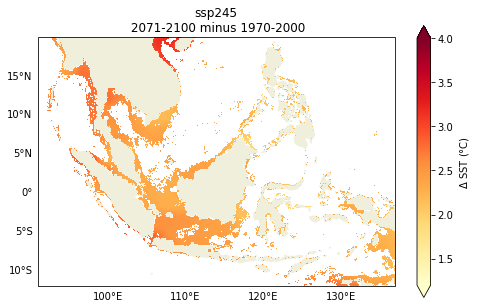

In [5]:
years_last = [2071,2100]
years_first = [1970,2000]
for i,experiment in enumerate(experiments):
    temp = xr.open_mfdataset(path+model+'/'+experiment+'/*'+variables[0]+'*.nc',combine='by_coords')        
    temp_last = temp.sel(time=temp['time.year'].isin(range(years_last[0],years_last[1]+1)))
    temp_first = temp.sel(time=temp['time.year'].isin(range(years_first[0],years_first[1]+1)))
    temp_clim_last = temp_last.mean(dim='time')
    temp_clim_first = temp_first.mean(dim='time')
    temp_diff = temp_clim_last - temp_clim_first
    fig = plt.figure(figsize=(8,10),facecolor='white')
    ax = fig.add_subplot(1, 1,1, projection=ccrs.PlateCarree())
    diff_ann = temp_diff.unknown.plot(ax=ax,transform=ccrs.PlateCarree(),add_colorbar=False,cmap='YlOrRd',vmin=1.2,vmax=4)
    ax.add_feature(cfeature.LAND)
    gl = ax.gridlines(draw_labels=True,linewidth=0, linestyle='--',alpha=0.5)
    gl.top_labels = False
    gl.right_labels = False
    ax.set_title(f'{experiment}\n 2071-2100 minus 1970-2000')
    cbar = plt.colorbar(diff_ann, ax=ax,shrink=0.5,extend='both')
    cbar.ax.set_ylabel(r"$\Delta$ SST (°C)");
    fig.savefig(f'img/Anomalies_proj_{model}_{experiment}.png',facecolor='white',dpi=300, bbox_inches='tight')

### Validation with Satellite SSTs (ESA CCI)

In [10]:
dfs = {}
model = models[0]
for experiment in experiments:
    temp = xr.open_mfdataset(path+model+'/'+experiment+'/*'+variables[0]+'*.nc',combine='by_coords')
    temp_ann = temp.resample(time='A', skipna=True).mean()
    sst_ann_ts = temp_ann.where(temp_ann.unknown<=50).mean(dim=['latitude','longitude']).to_dataframe()
    sst_ann_ts.index = sst_ann_ts.index.year
    dfs[experiment] = sst_ann_ts

In [6]:
lon_bnd=[temp.longitude.values.min(), temp.longitude.values.max()]
lat_bnd=[temp.latitude.values.min(), temp.latitude.values.max()]

In [7]:
### SST obtained from ESA-CCI satellite measurements 
cci_file = '../../../datasets/CCI_sst/ESACCI_monthly_SundaShelf.nc'
cci_sst= xr.open_mfdataset(cci_file)
cci_sst = cci_sst.assign_coords(lon=(((cci_sst.lon + 180) % 360) - 180))
cci_sst = cci_sst.sortby(cci_sst.lon)
cci_sst = cci_sst.sel(lon =slice(*lon_bnd), lat = slice(*lat_bnd), time=cci_sst['time.year']<=years[1])
cci_sst = cci_sst.assign(analysed_sst=cci_sst.analysed_sst-273.15)
cci_sst = cci_sst.rename({'analysed_sst':'sst','lat':'latitude','lon':'longitude'})
cci_sst_s = cci_sst.resample(time='QS-DEC', skipna=True).mean().load() ## Seasonal temperatures
cci_sst_yeari = int(cci_sst['time.year'].min().values) ## Earliest year
cci_clim = cci_sst_s.groupby("time.season").mean("time")

In [8]:
#### Regridding model to satellite grid
sst_model = temp.reindex(latitude=cci_sst.latitude, longitude=cci_sst.longitude, method='nearest')
sst_model = sst_model.where(sst_model.unknown<=50)
sst_model = sst_model.rename({'unknown':'sst'})
cci_sst_dom = cci_sst.where(sst_model.notnull())
### Select only the values from the model domain in the satellite data
cci_sst_dom = cci_sst.where(sst_model.notnull())
cci_sst_ts = cci_sst_dom.sst.mean(dim=['latitude','longitude']).resample(time='A', skipna=True).mean().to_dataframe()
cci_sst_ts.index = cci_sst_ts.index.year

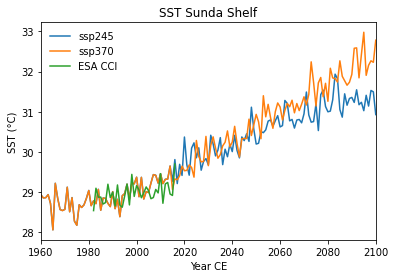

In [11]:
fig,axs = plt.subplots(facecolor='white')
dfs['ssp245']['unknown'].plot(ax=axs,label='ssp245')
dfs['ssp370']['unknown'].plot(ax=axs,label='ssp370')
cci_sst_ts.sst.plot(ax=axs,label='ESA CCI')
axs.legend(frameon=False);
axs.set_xlabel('Year CE');
axs.set_ylabel('SST (°C)');
axs.set_title('SST Sunda Shelf');
axs.set_xlim(1960,2100)
fig.savefig(f'img/{model}_annsst_vs_satellite.png',dpi=300, bbox_inches='tight')

In [12]:
cci_sst_yeari = int(cci_sst['time.year'].min().values) ## Earliest year
cci_sst_yearf = int(cci_sst['time.year'].max().values) ## Latest year in satellite data
cci_sst_s = cci_sst_dom.resample(time='QS-DEC', skipna=True).mean().load() ## Seasonal temperatures
cci_sst_ann = cci_sst_dom.resample(time='A', skipna=True).mean()
cci_clim = cci_sst_s.groupby("time.season").mean("time")
cci_clim_ann = cci_sst_ann.mean("time")
ssts_sims = {}
sim_minus_sat = {}
sim_minus_sat_ann = {}
for i,experiment in enumerate(experiments):
    temp = xr.open_mfdataset(path+model+'/'+experiment+'/*'+variables[0]+'*.nc',combine='by_coords')
    temp = temp.sel(time=temp['time.year'].isin(range(cci_sst_yeari,cci_sst_yearf+1)))
    temp = temp.where(temp['unknown']>=-2) ## Masking the values lower than -2
    temp = temp.rename({'unknown':'sst'})
    #### Regridding model to satellite grid
    temp = temp.reindex(latitude=cci_sst.latitude, longitude=cci_sst.longitude, method='nearest')
    temp_s = temp.resample(time='QS-DEC', skipna=True).mean().load()
    temp_ann = temp.resample(time='A', skipna=True).mean().load()
    temp_clim = temp_s.groupby("time.season").mean("time")
    temp_clim_ann = temp_ann.mean("time")
    dif_sim_cci = temp_clim - cci_clim
    dif_sim_cci_ann = temp_clim_ann - cci_clim_ann
    ssts_sims[experiment] = temp_s
    sim_minus_sat[experiment] = dif_sim_cci
    sim_minus_sat_ann[experiment] = dif_sim_cci_ann

In [13]:
fig = plt.figure(figsize=(8,10),facecolor='white')
ax = fig.add_subplot(1, 1,1, projection=ccrs.PlateCarree())
diff_ann = sim_minus_sat_ann['ssp245'].sst.plot(ax=ax,transform=ccrs.PlateCarree(),vmin=-4,vmax=4,add_colorbar=False,cmap='RdBu_r')
ax.coastlines(resolution='50m')
ax.add_feature(cfeature.LAND)
gl = ax.gridlines(draw_labels=True,linewidth=0, linestyle='--',alpha=0.5)
gl.top_labels = False
gl.right_labels = False
ax.set_title(f'Simulated SSTs ({model}-ssp245) minus Observations (CCI) \n {cci_sst_yeari}-{cci_sst_yearf}')
cbar = plt.colorbar(diff_ann, ax=ax,shrink=0.5,extend='both')
cbar.ax.set_ylabel(r"$\Delta$ SST (°C)");
fig.savefig(f'img/Sim_{model}_minus_CCI_annssts.png',facecolor='white',dpi=300, bbox_inches='tight')

### Comparing with UKESM1-0-LL SSTs

The ocean coordinates are defined in the native grid. 
So, the files were regridded to lat-lon coordinates using CDO:
`cdo remapbil,like_file.nc in.nc out.nc`

In [14]:
path_sst_hist = '../../../datasets/CMIP6/historical/UKESM1-0-LL/sst/tos_Oday_UKESM1-0-LL_historical_r1i1p1f2_all_latlon.nc'
path_sst_ssp245 = '../../../datasets/CMIP6/ssp245/UKESM1-0-LL/sst/tos_Oday_UKESM1-0-LL_ssp245_r1i1p1f2_all_latlon.nc'

UKESM_tos_hist = xr.open_mfdataset(path_sst_hist)
UKESM_tos_ssp245 = xr.open_mfdataset(path_sst_ssp245)
UKESM_tos = xr.merge([UKESM_tos_hist,UKESM_tos_ssp245])
del UKESM_tos_hist, UKESM_tos_ssp245
UKESM_tos = UKESM_tos.rename({'lat':'latitude','lon':'longitude'})
UKESM_tos = UKESM_tos.sel(longitude =slice(*lon_bnd), latitude = slice(*lat_bnd))
UKESM_tos = UKESM_tos.drop_vars(['time_bnds','lon_bnds','lat_bnds'])

In [15]:
def convert_to_dt(x):
    """
    from Datetime360 to datetime
    """
    return dt.strptime(str(x), '%Y-%m-%d %H:%M:%S')

In [16]:
experiment = 'ssp245'
sst_model = xr.open_mfdataset(path+model+'/'+experiment+'/*'+variables[0]+'*.nc',combine='by_coords')
sst_model_ann = sst_model.resample(time='AS', skipna=True).mean()
UKESM_tos_ann = UKESM_tos.resample(time='AS', skipna=True).mean()
sst_model_ann = sst_model_ann.rename({'unknown':'sst'})
sst_model_ann = sst_model_ann.where(sst_model_ann.sst<=50)
UKESM_tos_ann = UKESM_tos_ann.rename({'tos':'sst'})
UKESM_tos_ann['time'] = UKESM_tos_ann['time'].to_dataframe().time.apply(convert_to_dt)
#UKESM_tos_ann_rg = UKESM_tos_ann.reindex(latitude=sst_model.latitude, longitude=sst_model.longitude, method='nearest')
UKESM_tos_ann_rg = UKESM_tos_ann.reindex_like(sst_model_ann, method='nearest')
UKESM_tos_ann_dom = UKESM_tos_ann_rg.where(sst_model_ann.notnull())

In [17]:
years_tos = [1990,2020]
UKESM_tos_sely = UKESM_tos_ann_dom.sel(time=UKESM_tos_ann_dom['time.year'].isin(range(years_tos[0],years_tos[1]+1)))
sst_model_sely = sst_model_ann.sel(time=sst_model_ann['time.year'].isin(range(years_tos[0],years_tos[1]+1)))
UKESM_tos_clim = UKESM_tos_sely.mean("time")
sst_model_clim = sst_model_sely.mean('time')
dif_tos_model = sst_model_clim - UKESM_tos_clim

In [18]:
fig = plt.figure(figsize=(8,10),facecolor='white')
ax = fig.add_subplot(1, 1,1, projection=ccrs.PlateCarree())
diff_tos = dif_tos_model.sst.plot(ax=ax,transform=ccrs.PlateCarree(),vmin=-2.5,vmax=2.5,add_colorbar=False,cmap='RdBu_r')
#ax.coastlines(resolution='50m')
ax.add_feature(cfeature.LAND)
gl = ax.gridlines(draw_labels=True,linewidth=0, linestyle='--',alpha=0.5)
gl.top_labels = False
gl.right_labels = False
ax.set_title(f'S2P3v2 SSTs minus {model} SSTs  (ssp245) \n {years_tos[0]}-{years_tos[1]}')
cbar = plt.colorbar(diff_tos, ax=ax,shrink=0.5,extend='both')
cbar.ax.set_ylabel(r"$\Delta$ SST (°C)");
fig.savefig(f'img/modelledSSTs_minus_{model}_SST.png',facecolor='white',dpi=300, bbox_inches='tight')

In [19]:
UKESM_sst_ssp245 = UKESM_tos_ann_dom.mean(dim=['latitude','longitude']).to_dataframe()
model_sst_ssp245 = sst_model_ann.mean(dim=['latitude','longitude']).to_dataframe()
UKESM_sst_ssp245.index = UKESM_sst_ssp245.index.year
model_sst_ssp245.index = model_sst_ssp245.index.year

In [20]:
fig,axs = plt.subplots(facecolor='white')
UKESM_sst_ssp245['sst'].plot(ax=axs,label=f'{model}')
model_sst_ssp245['sst'].plot(ax=axs,label='S2P3v2')
axs.legend(frameon=False);
axs.set_xlabel('Year CE');
axs.set_ylabel('SST (°C)');
axs.set_title(f'Sunda Shelf SSTs ({experiment})');
axs.set_xlim(1960,2100)
fig.savefig(f'img/{model}_SSTs_vs_S2P3v2.png',dpi=300, bbox_inches='tight')

### Visualising SSTs from a domain with depths ranging between 4 and 100 meters

The idea of this simulation is to obtain more grid-points around the Phlipines. However, given the bathymetry of the region, few points are added in that area. 
This simulation takes as twice as the simulations comprising 4-50m depths.

In [21]:
experiment = 'ssp245_100m'
temp = xr.open_mfdataset(path+model+'/'+experiment+'/*'+variables[0]+'*.nc',combine='by_coords')
temp = temp.sel(time=temp['time.year'].isin(range(2030,2060+1)))
temp_clim = temp.mean(dim='time')

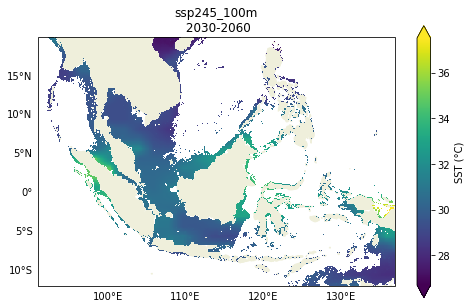

In [22]:
fig = plt.figure(figsize=(8,10),facecolor='white')
ax = fig.add_subplot(1, 1,1, projection=ccrs.PlateCarree())
sst = temp_clim.unknown.plot(ax=ax,transform=ccrs.PlateCarree(),add_colorbar=False)
ax.add_feature(cfeature.LAND)
gl = ax.gridlines(draw_labels=True,linewidth=0, linestyle='--',alpha=0.5)
gl.top_labels = False
gl.right_labels = False
ax.set_title(f'{experiment}\n 2030-2060')
cbar = plt.colorbar(sst, ax=ax,shrink=0.5,extend='both')
cbar.ax.set_ylabel(r"SST (°C)");
fig.savefig(f'img/SST_{model}_{experiment}.png',facecolor='white',dpi=300, bbox_inches='tight')